# SVM

This notebook was run on an Amazon SageMaker ml.c5.4xlarge instance.  

In [122]:
import pandas as pd
import string
import re
import string
import numpy as np
import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer 

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
import pickle_functions as pf

In [5]:
import model_functions as mf

### Load and shuffle data

Read in test.csv and train.csv

In [6]:
train = pf.read_pickle(bucket_name='advancedml-koch-mathur-hinkson', filename='sub_train_df14_preprocessed')

In [7]:
drop_cols = ['split', 'cleaned_w_stopwords', 'cleaned_no_stem', 'cleaned_porter', 'cleaned_lancaster', 'bigrams_unstemmed',
       'perc_upper', 'num_exclam', 'num_words', 'perc_stopwords',
       'num_upper_words']

In [8]:
train = train.drop(drop_cols, axis = 1)

In [9]:
train.shape

(100000, 49)

In [10]:
train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str'],
      dtype='object')

Create a new column called "toxicity_category" in the train data frame categorizing comments as toxic ("1") or non-toxic ("0").

In [11]:
train['toxicity_category'] = train.target.apply(lambda x: 1 if x > 0.5 else 0)

Split train.csv into training (80%) and hold out sets (20%).

In [12]:
#Citation: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk]
hold_out_set = train[~msk]

In [13]:
print(train_set.toxicity_category.value_counts())

0    74666
1     5338
Name: toxicity_category, dtype: int64


In [14]:
print(hold_out_set.toxicity_category.value_counts())

0    18678
1     1318
Name: toxicity_category, dtype: int64


In [15]:
print(train_set.toxicity_category.value_counts())

0    74666
1     5338
Name: toxicity_category, dtype: int64


In [16]:
toxic = train_set[train_set.toxicity_category == 1]
nontoxic = train_set[train_set.toxicity_category == 0]

In [17]:
train_set.shape, toxic.shape, nontoxic.shape

((80004, 50), (5338, 50), (74666, 50))

Reshaping the dataset to be include an equal number of toxic and nontoxic samples

In [18]:
quarter = len(toxic)

In [19]:
random_df = train_set.sample(quarter*4)

Create a data set of 25% toxic and 75% nontoxic comments, and shuffle the data such that you do not have a data set of grouped toxic and grouped nontoxic comments

In [20]:
prepared_25 = toxic.append(nontoxic.sample(len(toxic)*3))
prepared_25 = prepared_25.sample(frac=1).reset_index(drop=True)
print(prepared_25.toxicity_category.value_counts())

0    16014
1     5338
Name: toxicity_category, dtype: int64


### SVM - weighted 1/3 toxic, 2/3 nontoxic

In [36]:
prepared_33 = toxic.append(nontoxic.sample(len(toxic)*2))
prepared_33 = prepared_33.sample(frac=1).reset_index(drop=True)
print(prepared_33.toxicity_category.value_counts())

0    10664
1     5332
Name: toxicity_category, dtype: int64


In [37]:
classifier, output, fitted_vectorizer = mf.run_model(model_df=prepared_33, 
                                                     model_type="SVM", 
                                                     comments = "cleaned_no_stem_str", 
                                                     train_perc=0.95, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [38]:
hold_out_results = mf.run_model_test(model_df=hold_out_set, 
                                     clf=classifier, 
                                     vectorizer=fitted_vectorizer, 
                                     comments="cleaned_no_stem_str", target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str', 'toxicity_category', 'predicted', 'y_test'],
      dtype='object')


In [39]:
hold_out_metrics = mf.get_metrics(output=hold_out_results, detailed=True, should_print=True, round_to=3)

Overall Accuracy: 0.9248949845639961
Overall Precision: 0.45987963891675027
Overall Recall: 0.6925981873111783
Overall F1 Score: 0.5527426160337553
ROC_AUC: 0.817

Target Accuracy: 0.6925981873111783
Target Precision: 1.0
Target Recall: 0.6925981873111783
Target F1 Score: 0.8183846497099508

Non-Target Accuracy: 0.9415785191212368
Non-Target Precision: 1.0
Non-Target Recall: 0.9415785191212368
Non-Target F1 Score: 0.9699103176598776

Strong Identity Accuracy: 0.6535433070866141
Strong Identity Precision: 0.9425287356321839
Strong Identity Recall: 0.6776859504132231
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.7611940298507462
Obscenity Precision: 1.0
Obscenity Recall: 0.7611940298507462
Obscenity F1 Score: 1.0

Insults Accuracy: 0.742914979757085
Insults Precision: 0.9849108367626886
Insults Recall: 0.7471383975026015
Insults F1 Score: 1.0

Threats Accuracy: 0.3793103448275862
Threats Precision: 1.0
Threats Recall: 0.35714285714285715
Threats F1 Score: 1.0



### SVM - weighted 25% toxic, 75% nontoxic

In [21]:
classifier, output, fitted_vectorizer = mf.run_model(model_df=prepared_25, 
                                                     model_type="SVM", 
                                                     comments = "cleaned_no_stem_str", 
                                                     train_perc=0.95, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [80]:
output.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,identity_annotator_count,toxicity_annotator_count,cleaned_w_stopwords_str,cleaned_no_stem_str,cleaned_porter_str,cleaned_lancaster_str,toxicity_category,predicted,y_test,accuracy
20284,5714292,0.600000,It was stated in the same tone as when Barack ...,0.000000,0.100000,0.100000,0.500000,0.000000,NaN,NaN,...,0,10,It was stated in the same tone as when Barack ...,it stated tone barack hussein obama stated nat...,it state tone barack hussein obama state natio...,it stat ton barack hussein obam stat nat tv th...,1,0,1,False
20285,5820925,0.000000,It would be nice to know from the population w...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,0,4,It would be nice to know from the population w...,it would nice know population whether thinks c...,it would nice know popul whether think cost wo...,it would nic know pop wheth think cost wor man...,0,1,0,False
20286,5751293,0.000000,"""That never attended one?"" I never bothered w...",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,0,4,That never attended one I never bothered with...,that never attended one i never bothered colle...,that never attend one i never bother colleg ev...,that nev attend on i nev both colleg ev i know...,0,0,0,True
20287,5763154,0.200000,"I'm actually kind of ""meh"" about statue remova...",0.000000,0.000000,0.100000,0.200000,0.000000,0.0,0.0,...,5,10,I'm actually kind of meh about statue removal ...,i'm actually kind meh statue removal i felt st...,i'm actual kind meh statu remov i felt strongl...,i'm act kind meh statu remov i felt strongly w...,0,0,0,True
20288,5719487,0.200000,The study is flawed w/ its ratings for tickets...,0.000000,0.000000,0.000000,0.200000,0.000000,NaN,NaN,...,0,10,The study is flawed w its ratings for tickets ...,the study flawed w ratings tickets running red...,the studi flaw w rate ticket run red light her...,the study flaw w rat ticket run red light her ...,0,0,0,True
20289,5715631,0.400000,Are you also suggesting therefore that Roman C...,0.000000,0.000000,0.400000,0.200000,0.100000,0.0,0.0,...,4,10,Are you also suggesting therefore that Roman C...,are also suggesting therefore roman catholics ...,are also suggest therefor roman cathol jew sho...,ar also suggest theref rom cathol jew should n...,0,0,0,True
20290,5719524,0.000000,We are building a refinery. With huge governme...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,0,4,We are building a refinery With huge governmen...,we building refinery with huge government subs...,we build refineri with huge govern subsidi and...,we build refinery with hug govern subsidy and ...,0,0,0,True
20291,5796769,0.600000,"I think the guy is a creep, but please list th...",0.100000,0.100000,0.000000,0.600000,0.000000,NaN,NaN,...,0,10,I think the guy is a creep but please list the...,i think guy creep please list crime would/coul...,i think guy creep pleas list crime would/could...,i think guy creep pleas list crim would/could ...,1,0,1,False
20292,5816815,0.000000,You actually have the answer. It's knowledge. ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,5,4,You actually have the answer It's knowledge Kn...,you actually answer it's knowledge knowledge c...,you actual answer it' knowledg knowledg creat ...,you act answ it's knowledg knowledg cre weal m...,0,0,0,True
20293,5787192,0.657143,Anyone who doesn't think they won't go after W...,0.057143,0.057143,0.285714,0.642857,0.014286,0.0,0.0,...,4,70,Anyone who doesn't think they won't go after W...,anyone think won't go washington jefferson pig...,anyon think won't go washington jefferson pig ...,anyon think won't go washington jefferson pig ...,1,1,1,True


In [22]:
mf.get_metrics(output=output, detailed=True, should_print=True, round_to=3)

Overall Accuracy: 0.8857677902621723
Overall Precision: 0.9042553191489362
Overall Recall: 0.6204379562043796
Overall F1 Score: 0.7359307359307359
ROC_AUC: 0.799

Target Accuracy: 0.6204379562043796
Target Precision: 1.0
Target Recall: 0.6204379562043796
Target F1 Score: 0.7657657657657658

Non-Target Accuracy: 0.9773299748110831
Non-Target Precision: 1.0
Non-Target Recall: 0.9773299748110831
Non-Target F1 Score: 0.9885350318471338

Strong Identity Accuracy: 0.5555555555555556
Strong Identity Precision: 1.0
Strong Identity Recall: 0.5555555555555556
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.7857142857142857
Obscenity Precision: 1.0
Obscenity Recall: 0.7857142857142857
Obscenity F1 Score: 1.0

Insults Accuracy: 0.671875
Insults Precision: 0.9923076923076923
Insults Recall: 0.675392670157068
Insults F1 Score: 1.0

Threats Accuracy: 0.5714285714285714
Threats Precision: 1.0
Threats Recall: 0.5714285714285714
Threats F1 Score: 1.0



{'Overall': {'Accuracy': 0.8857677902621723,
  'Precision': 0.9042553191489362,
  'Recall': 0.6204379562043796,
  'F1': 0.7359307359307359,
  'ROC_AUC': 0.799},
 'Target': {'Accuracy': 0.6204379562043796,
  'Precision': 1.0,
  'Recall': 0.6204379562043796,
  'F1': 0.7657657657657658},
 'Non-Target': {'Accuracy': 0.5714285714285714,
  'Precision': 1.0,
  'Recall': 0.5714285714285714,
  'F1': 1.0}}

In [23]:
hold_out_results = mf.run_model_test(model_df=hold_out_set, 
                                     clf=classifier, 
                                     vectorizer=fitted_vectorizer, 
                                     comments="cleaned_no_stem_str", target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str', 'toxicity_category', 'predicted', 'y_test'],
      dtype='object')


In [24]:
# hold_out_results.to_csv("holdout_results", sep='|')

In [25]:
hold_out_metrics = mf.get_metrics(output=hold_out_results, detailed=True, should_print=True, round_to=3)

Overall Accuracy: 0.9451890378075615
Overall Precision: 0.5786118980169972
Overall Recall: 0.6198786039453718
Overall F1 Score: 0.5985347985347984
ROC_AUC: 0.794

Target Accuracy: 0.6198786039453718
Target Precision: 1.0
Target Recall: 0.6198786039453718
Target F1 Score: 0.7653395784543325

Non-Target Accuracy: 0.9681443409358603
Non-Target Precision: 1.0
Non-Target Recall: 0.9681443409358603
Non-Target F1 Score: 0.9838143684883436

Strong Identity Accuracy: 0.5740740740740741
Strong Identity Precision: 0.9482758620689655
Strong Identity Recall: 0.5612244897959183
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.6521739130434783
Obscenity Precision: 1.0
Obscenity Recall: 0.6521739130434783
Obscenity F1 Score: 1.0

Insults Accuracy: 0.7070193285859614
Insults Precision: 0.9912917271407837
Insults Recall: 0.7077720207253886
Insults F1 Score: 1.0

Threats Accuracy: 0.24
Threats Precision: 1.0
Threats Recall: 0.24
Threats F1 Score: 0.0



### Feature Importance

In [83]:
imp = classifier.coef_.todense().tolist()[0]
imp2, names = zip(*sorted(zip(imp,feature_names)))

top_pos = np,
plt.barh(range(len(names)), names)
plt.yticks(range(len(names)), names)
plt.show()
imp

In [132]:
imps = imp2[-10:] + imp2[:10]
words = names[-10:] + names[:10]

In [133]:
tograph = pd.DataFrame()
tograph['importances'] = imps
tograph['words'] = words
tograph['type'] = tograph.importances.apply(lambda x: 1 if x > 0 else 0)

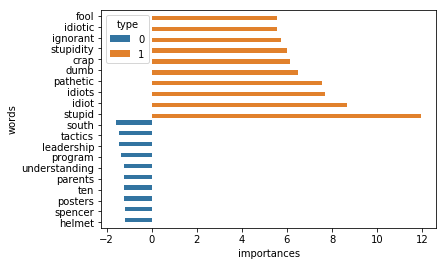

In [134]:
sns.barplot(x="importances", y="words", data=tograph, hue="type")